# Первичный анализ данных из БД

In [263]:
import psycopg2
import pandas as pd

In [3]:
HOST = 'ep-green-butterfly-a26qo6f3.eu-central-1.aws.neon.tech'
PORT = 5432
DATABASE = 'datadb'
USER = 'datadb_owner'
PASSWORD = 'BmV3l0GArdNT'

In [231]:
connection = psycopg2.connect(
    host = HOST,
    port = PORT,
    database = DATABASE,
    user = USER,
    password = PASSWORD,
)

In [53]:
connection

<connection object at 0x000001E6C8F2CF20; dsn: 'user=datadb_owner password=xxx dbname=datadb host=ep-green-butterfly-a26qo6f3.eu-central-1.aws.neon.tech port=5432', closed: 0>

In [198]:
cursor = connection.cursor()
query = """select * from cd.inflation"""
cursor.execute(query)
data = cursor.fetchall()
cursor.close()
InfDf = pd.DataFrame(data, columns = ['infid', 'inflation', 'data'])

In [199]:
InfDf

,infid,inflation,data
0,0,28.93,2000-01-01
1,1,25.11,2000-02-01
2,2,22.49,2000-03-01
3,3,19.95,2000-04-01
4,4,19.40,2000-05-01
...,...,...,...
140,140,3.05,2019-01-01
141,141,4.91,2020-01-01
142,142,8.39,2021-01-01
143,143,11.92,2022-01-01


## Цель:
1. Вывести инфляцию в виде графика
2. Вывести рост зарплат по профессиям (сделать категорию)
3. Вывести в один график зарплату и инфляцию

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Получение данных из БД

In [200]:
cursor = connection.cursor()
query = """select to_char(i.infdata, 'YYYY') as year, round(avg(i.inflation), 2) as inflation 
from cd.inflation i 
group by to_char(i.infdata, 'YYYY')
order by to_char(i.infdata, 'YYYY');"""
cursor.execute(query)
data = cursor.fetchall()
cursor.close()
InfDf = pd.DataFrame(data, columns = ['years', 'inflation'])

## Вывод инфляции на изображение

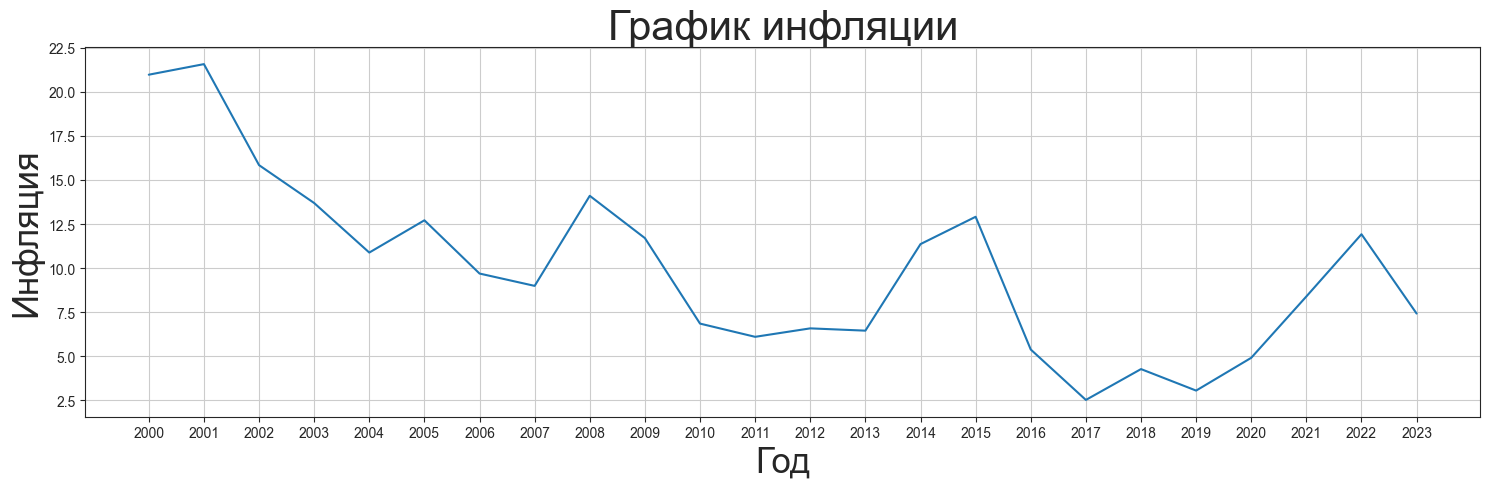

In [201]:
plt.figure(figsize=(15,5))
axes = sns.lineplot(data=InfDf, x="years", y="inflation")
plt.title('График инфляции', fontsize=30)
axes.set_xlabel('Год', fontsize=25)
axes.set_ylabel('Инфляция', fontsize=25)
plt.grid(True)
plt.tight_layout()
plt.show()

## Вывести рост зарплат

In [57]:
cursor = connection.cursor()
query = """select * 
from cd.nameprof n;"""
cursor.execute(query)
data = cursor.fetchall()
cursor.close()
profName = pd.DataFrame(data = data, columns = ['nameid', 'name'])

In [61]:
profName

,nameid,name
0,0,Врачи
1,1,Преподаватели ВО
2,2,Научные сотрудники


In [232]:
def get_salary(name):
    cursor = connection.cursor()
    query = "select p.profid, n.nameprof, p.salary, to_char(p.salarydata, 'YYYY') from cd.profession p join cd.nameprof n on p.profnameid = n.nameid where n.nameprof = %s;"
    cursor.execute(query, (name, ))
    data = cursor.fetchall()
    cursor.close()
    dataProf = pd.DataFrame(data = data, columns = ['nameid', 'nameprof', 'salary', 'years'])
    return dataProf
name = "Врачи"
dataProf = get_salary(name)


In [338]:
dataProf['true_salary'] = dataProf['salary'] * 1000

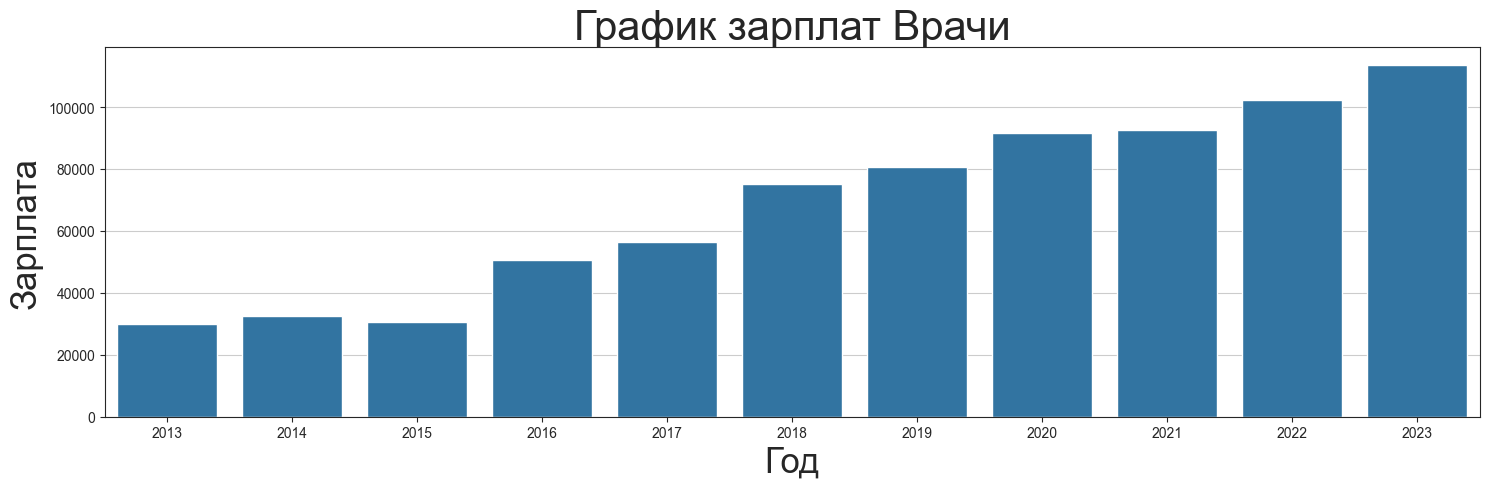

In [204]:
plt.figure(figsize = (15,5))
axes = sns.barplot(data=dataProf, x = 'year', y = 'true_salary')
plt.title('График зарплат %s' % name, fontsize = 30)
axes.set_xlabel('Год', fontsize = 25)
axes.set_ylabel('Зарплата', fontsize = 25)
plt.tight_layout()
plt.show()

## График зарплат и инфляции в одном графике

In [299]:
InfDf['year'] = (pd.to_datetime(InfDf['years']) - pd.DateOffset(years=1)).dt.year
dataProf['year'] = (pd.to_datetime(dataProf['years'])).dt.year
newDf = pd.merge(InfDf[['inflation','year']], dataProf[['nameprof','salary','year']], how = 'inner', on = 'year')
newDf['true_salary'] = newDf['salary'] * 1000
newDf['newSalary'] = newDf['true_salary'] * (1 + newDf['inflation'] / 100)

In [335]:
newDf['new_salary'] = pd.concat([pd.Series(newDf.iloc[0,4]),newDf[:-1]['newSalary']], ignore_index = True)
newDf

,inflation,year,nameprof,salary,true_salary,newSalary,new_salary
0,11.36,2013,Врачи,29.960,29960.000,33363.4560000,29960.000
1,12.91,2014,Врачи,32.611,32611.000,36821.0801000,33363.4560000
2,5.38,2015,Врачи,30.694,30694.000,32345.3372000,36821.0801000
3,2.52,2016,Врачи,50.667,50667.000,51943.8084000,32345.3372000
4,4.27,2017,Врачи,56.445,56445.000,58855.2015000,51943.8084000
5,3.05,2018,Врачи,75.007,75007.000,77294.7135000,58855.2015000
6,4.91,2019,Врачи,80.756,80756.000,84721.1196000,77294.7135000
7,8.39,2020,Врачи,91.688,91688.000,99380.6232000,84721.1196000
8,11.92,2021,Врачи,92.460,92460.000,103481.2320000,99380.6232000
9,7.42,2022,Врачи,102.232,102232.000,109817.6144000,103481.2320000


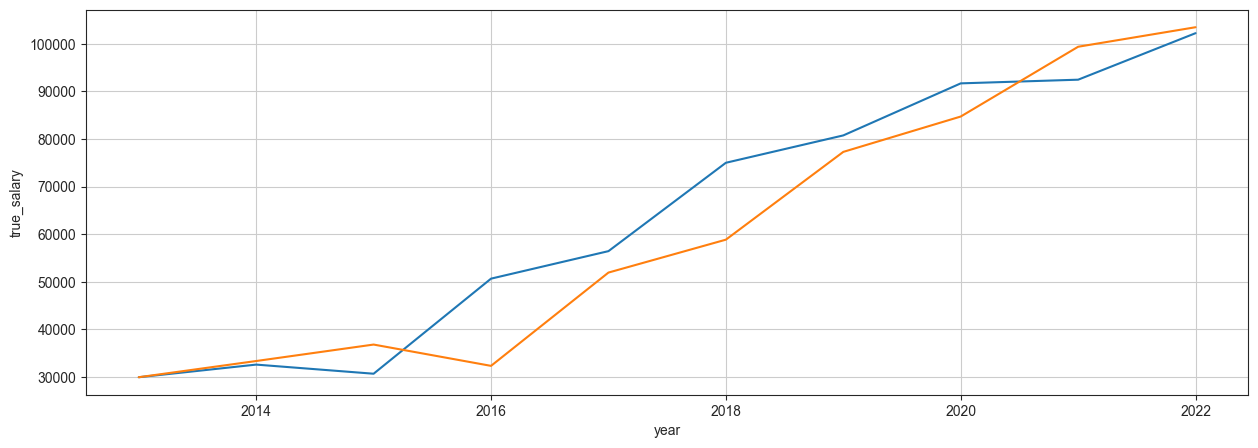

In [345]:
fig, axes = plt.subplots(1, 1, figsize = (15, 5))
sns.lineplot(data=newDf, x = 'year', y = 'true_salary', ax=axes)
sns.lineplot(data=newDf, x = 'year', y = 'new_salary', ax=axes)
plt.show()